In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import qutip as qt 
from ECD_control.ECD_optimization.batch_optimizer_new import BatchOptimizer
from ECD_control.gate_sets import ECDGateSet
from ECD_control.ECD_optimization.GateSynthesizer import GateSynthesizer
from ECD_control.ECD_optimization.optimization_analysis import OptimizationAnalysis, OptimizationSweepsAnalysis
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

2022-02-14 16:58:55.195816: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-14 16:58:55.195831: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



Need tf version 2.3.0 or later. Using tensorflow version: 2.8.0


Need tf version 2.3.0 or later. Using tensorflow version: 2.8.0



In [2]:
#The target oscillator state.
N = 40
Fock = 3
psi_t = qt.basis(N,3) #target state

gate_set_params = {
    'N_blocks' : 7, #circuit depth
    'N_cav' : N,
    'beta_scale' : 3.0, #maximum |beta| for random initialization
    'beta_mask' : None,
    'phi_mask' : None,
    'eta_mask' : None,
    'theta_mask' : None,
    'alpha_mask' : None,
    'beta_scale' : 1.0,
    'alpha_scale' : 1.0,
    'theta_scale' : np.pi,
    'use_etas' : False,
    'use_displacements' : False,
    'no_CD_end' : False
    
}

# We initialize the ECDGateSet here
ECD_gate_set = ECDGateSet(**gate_set_params)

2022-02-14 16:58:55.984705: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-14 16:58:55.984721: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-14 16:58:55.984731: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sauron): /proc/driver/nvidia/version does not exist
2022-02-14 16:58:55.984875: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#Optimization of ECD Circuit parameters (betas, phis, and thetas)
#the optimization options
synth_params = {
    'gateset' : ECD_gate_set,
    'N_multistart' : 200, #Batch size (number of circuit optimizations to run in parallel)
    'epochs' : 200, #number of epochs before termination
    'epoch_size' : 10, #number of adam steps per epoch
    'learning_rate' : 0.01, #adam learning rate
    'term_fid' : 0.995, #terminal fidelitiy
    'dfid_stop' : 1e-6, #stop if dfid between two epochs is smaller than this number
    'beta_scale' : 3.0, #maximum |beta| for random initialization
    'initial_states' : [qt.tensor(qt.basis(2,0),qt.basis(N,0))], #qubit tensor oscillator, start in |g> |0>
    'target_states' : [qt.tensor(qt.basis(2,1), psi_t)], #end in |e> |target>.
    'name' : 'Fock %d' % Fock, #name for printing and saving
    'filename' : None, #if no filename specified, results will be saved in this folder under 'name.h5'
}

gatesynth = GateSynthesizer(**synth_params)

#note: optimizer includes pi pulse in every ECD step. However, final ECD step is implemented 
#in experiment as a displacement since the qubit and oscillator should be disentangled at this point.
#So, we ask the optimizer to end in |e> |target> instead of |g>|target>.

In [4]:
#create optimization object. 
#initial params will be randomized upon creation
opt = BatchOptimizer(gatesynth)

#print optimization info. this lives in gatesynth, since we eventually want to fully abstract away the optimizer
gatesynth.print_info()

filename: Fock 3.h5

Best circuit parameters found:
betastf.Tensor(
[-0.16194+0.27034j -0.5148 -0.49058j -0.70785-0.10316j  0.59248-0.05515j
 -0.76563-0.23959j  0.48372-0.59951j -0.2466 -0.37414j], shape=(7,), dtype=complex64)
phistf.Tensor([ 0.       1.38286 -1.10329  1.87744 -1.39203 -2.15119 -1.80654], shape=(7,), dtype=float32)
etastf.Tensor([1.5708 1.5708 1.5708 1.5708 1.5708 1.5708 1.5708], shape=(7,), dtype=float32)
thetastf.Tensor([ 3.08289 -0.55263 -0.75141 -0.50963  1.54188  2.41271 -3.03892], shape=(7,), dtype=float32)




In [5]:
#run optimizer.
#note the optimizer can be stopped at any time by interrupting the python consle,
#and the optimization results will still be saved and part of the opt object.
#This allows you to stop the optimization whenever you want and still use the result.
opt.optimize()

Start time: 2022-02-14 16:58:59


TypeError: in user code:

    File "/home/rsl/ECD_control/ECD_control/ECD_optimization/batch_optimizer_new.py", line 77, in entry_stop_gradients  *
        for k in zip(vars, mask): # I think this for loop should be fine. It's no different than calling all these in a row. Could also reshape all inputs into one large tf.variable

    TypeError: zip argument #2 must support iteration


In [7]:
#can print info, including the best circuit found.
opt.print_info() 

optimization_type: state transfer
N_multistart: 200
N_blocks: 7
term_fid: 0.995
dfid_stop: 1e-06
no_CD_end: False
learning_rate: 0.01
epoch_size: 10
epochs: 200
beta_scale: 3.0
alpha_scale: 1.0
theta_scale: 3.141592653589793
use_etas: False
use_displacements: False
use_phase: False
name: Fock 3
comment: 
N_cav: 40
filename: Fock 3.h5

Best circuit parameters found:
betas:         [-1.6746 +0.9689j  -0.4266 -1.61134j -1.274  -0.22163j -0.42474+0.38194j
 -1.00143-0.69088j -0.80892-0.53196j -0.0019 -0.00145j]
alphas:        [0.+0.j]
phis (deg):    [  0.      -89.38478 -91.09796 -88.44789 -92.03095 -87.6295   -1.84445]
etas (deg):    [89.99999 89.99999 89.99999 89.99999 89.99999 89.99999 89.99999]
thetas (deg):  [  90.02281   80.54354 -124.37192  -95.91251  -58.29166  -24.57762
   89.50047]
Max Fidelity:  0.995642




In [8]:
#can also get the best circuit parameters directly, could save this to a .npz file.
best_circuit =  opt.best_circuit()
betas = best_circuit['betas']
phis = best_circuit['phis']
thetas = best_circuit['thetas']
print(best_circuit)

{'fidelity': 0.9956418, 'betas': array([-1.6746027 +9.6890062e-01j, -0.4265962 -1.6113380e+00j,
       -1.2739965 -2.2163001e-01j, -0.42474332+3.8194054e-01j,
       -1.0014281 -6.9088477e-01j, -0.8089165 -5.3195804e-01j,
       -0.00189993-1.4480036e-03j], dtype=complex64), 'alphas': array([0.+0.j], dtype=complex64), 'phis': array([ 0.        , -1.5600588 , -1.5899594 , -1.543707  , -1.6062431 ,
       -1.5294234 , -0.03219175], dtype=float32), 'etas': array([1.5707963, 1.5707963, 1.5707963, 1.5707963, 1.5707963, 1.5707963,
       1.5707963], dtype=float32), 'thetas': array([ 1.5711944 ,  1.40575   , -2.1706996 , -1.673989  , -1.0173814 ,
       -0.42896032,  1.5620778 ], dtype=float32)}


In [9]:
#Analysis of the results. Can load the .h5 file.
#all data is stored as a timestamp in a .h5 file
#You can also specify which timestamp you are analyzing. Be defult, it will use the most recent optimization in the file.
#I  recommend using "HDFview" software to understand data structure
#filename = opt.filename
filename = 'Fock %d.h5' % Fock
analysis = OptimizationAnalysis(filename)
analysis.print_info() #we can print info of best circuit

N_blocks: 7
N_cav: 40
N_multistart: 200
alpha_scale: 1.0
beta_scale: 3.0
comment: 
dfid_stop: 1e-06
elapsed_time_s: 117.42283606529236
epoch_size: 10
epochs: 200
learning_rate: 0.01
name: Fock 3
no_CD_end: False
optimization_type: state transfer
term_fid: 0.995
termination_reason: term_fid
theta_scale: 3.141592653589793
use_displacements: False
use_etas: False
use_phase: False
filename: Fock 3.h5

Best circuit parameters found:
betas:         [-1.6746 +0.9689j  -0.4266 -1.61134j -1.274  -0.22163j -0.42474+0.38194j
 -1.00143-0.69088j -0.80892-0.53196j -0.0019 -0.00145j]
alphas:        [0.+0.j]
phis (deg):    [  0.      -89.38478 -91.09796 -88.44789 -92.03095 -87.6295   -1.84445]
thetas (deg):  [  90.02281   80.54354 -124.37192  -95.91251  -58.29166  -24.57762
   89.50047]
Max Fidelity:  0.995637




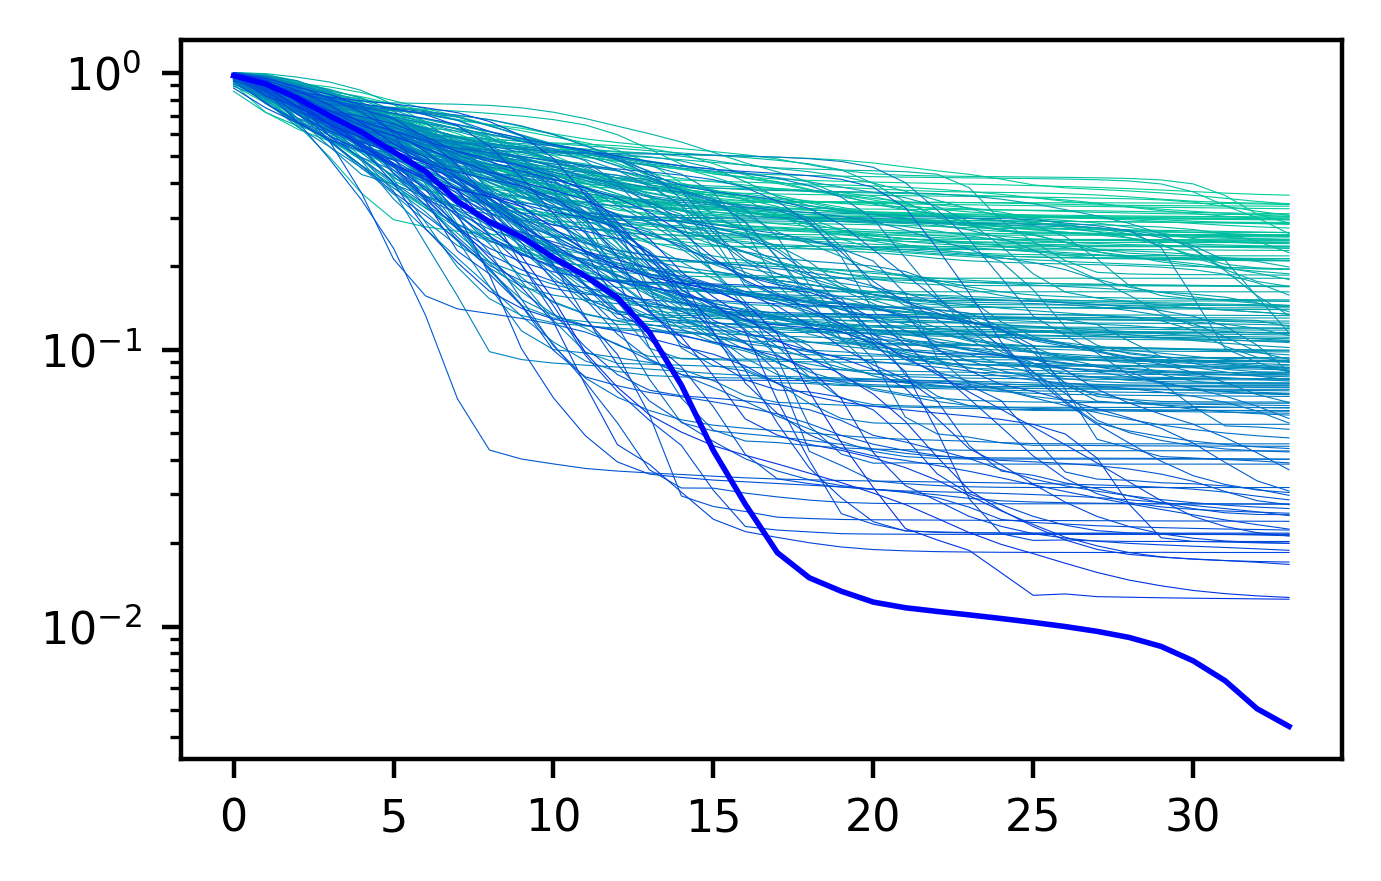

In [10]:
#We can plot the fidelities of the different parallel optimizations. 
# x axis is epoch
analysis.plot_fidelities()

In [11]:
#Can also get the "best circuit" from a loaded analysis object
best_circuit = analysis.best_circuit()
betas = best_circuit['betas']
phis = best_circuit['phis']
thetas = best_circuit['thetas']
print(best_circuit)

{'fidelity': 0.9956374, 'betas': array([-1.6746027 +9.6890062e-01j, -0.4265962 -1.6113380e+00j,
       -1.2739965 -2.2163001e-01j, -0.42474332+3.8194054e-01j,
       -1.0014281 -6.9088477e-01j, -0.8089165 -5.3195804e-01j,
       -0.00189993-1.4480036e-03j], dtype=complex64), 'alphas': array([0.+0.j], dtype=complex64), 'phis': array([ 0.        , -1.5600588 , -1.5899594 , -1.543707  , -1.6062431 ,
       -1.5294234 , -0.03219175], dtype=float32), 'thetas': array([ 1.5711944 ,  1.40575   , -2.1706996 , -1.673989  , -1.0173814 ,
       -0.42896032,  1.5620778 ], dtype=float32)}


In [12]:
#Now, we can take the parameters found (betas, phis, and thetas)
#and use them to produce a ECD oscillator and qubit pulse.
#This requies us to specify the calibrated experimental parameters.

#The following parameters for the oscillator will be used to build the oscillator pulse.
#Here, assume that a gaussian displacement pulse to alpha=1.0 has been calibrated.
storage_params = {
        "chi_kHz": 33, #dispersive shift in kHz
        "chi_prime_Hz": 1, #second order dispersive shift in Hz
        "Ks_Hz": 0, #Kerr correction not implemented here.
        "unit_amp": 0.01, #DAC amplitude (at maximum of pulse) for gaussian displacement to alpha=1.
        "sigma": 11, #oscillator displacement pulse sigma
        "chop": 4, #oscillator displacement pulse chop (number of sigmas to include in gaussian pulse)
    }

#In a similar way, the qubit pulse parameters will be specified by a calibrated pi pulse.
#unit_amp is the DAC amplitude (at maximum of pulse) for a calibrated gaussian pi pulse, with sigma and chop specified
qubit_params = {'unit_amp': 0.5, 'sigma': 6, 'chop': 4} #parameters for qubit pi pulse.


#creating the "Fake storage" and "Fake qubit" objects which are used
#for pulse cration
storage = FakeStorage(**storage_params)
qubit = FakeQubit(**qubit_params)

#The maximum displacement used during the ECD gates.
alpha_CD = 30
#Small delay to insert between oscillator and qubit pulses to ensure timing is okay.
buffer_time = 4

In [13]:
#From these calibrations, the storage and qubit objects calculate the
#conversion between DAC amplitude, and drive amplitude in MHz.
#so, [Omega(t) in MHz] = [Omega(t) in DAC units]*Omega_m_MHz 
#and [Omega(t) in MHz] = [Omega(t) in DAC units]*Omega_m_MHz.
#These parameters also represent the maximum drive amplitude,
#since the DAC max amplitude is 1 (assuming amplifiers don't saturate.)
print('Maximum oscillator drive amplitude: |epsilon|/2*pi < %.3f MHz' % storage.epsilon_m_MHz)
print('Maximum qubit drive amplitude: |Omega|/2*pi < %.3f MHz' % qubit.Omega_m_MHz)

Maximum oscillator drive amplitude: |epsilon|/2*pi < 690.790 MHz
Maximum qubit drive amplitude: |Omega|/2*pi < 40.468 MHz


In [14]:
#generating the oscillator and qubit pulses (epsilon and Omega)
#set 'chi_prime_correction = True' to correct for linear part of chi'
#final_disp = True will implement final ECD gate as a gaussian displacement instead of full ECD gate.
#This option is useful if the qubit and oscillator are disentangled after the gate.
pulse_dict = conditional_displacement_circuit(betas, phis, thetas, storage, qubit,
                     alpha_CD,buffer_time=buffer_time, kerr_correction = False, chi_prime_correction=True, final_disp=True, pad=True)

#The dictionary will contain the pulses, in DAC units.
#Also, the displacements used for each ECD gate (the "alphas")
cavity_dac_pulse, qubit_dac_pulse,alphas = pulse_dict['cavity_dac_pulse'], pulse_dict['qubit_dac_pulse'], pulse_dict['alphas']
print('alphas:')
print(alphas)

/home/rsl/miniconda3/envs/jupyterhub/lib/python3.7/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


alphas:
[30.04311449177611, 30.1959048013861, 30.10215372980626, 29.45709051161263, 30.16427503275452, 30.22088604451357]


Text(0.5, 0, 'ns')

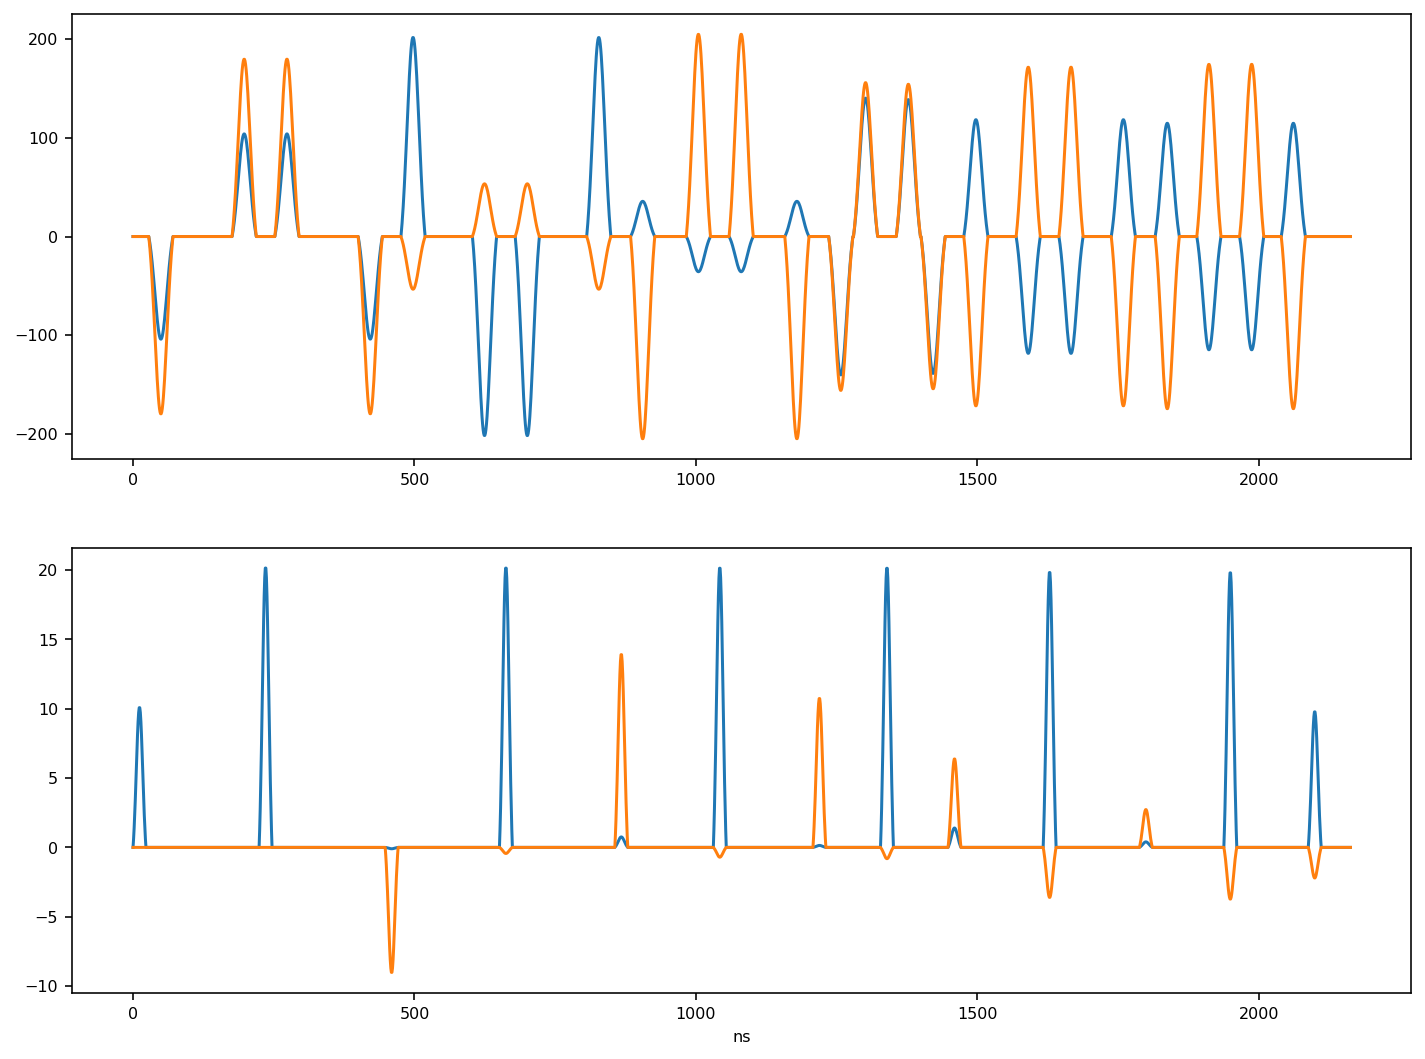

In [15]:
#plotting the pulse, in units of MHz. It could also be fed into a time-domain simulation.
fig, axs = plt.subplots(2,1)
axs[0].plot(np.real(storage.epsilon_m_MHz*cavity_dac_pulse))
axs[0].plot(np.imag(storage.epsilon_m_MHz*cavity_dac_pulse))
axs[1].plot(np.real(qubit.Omega_m_MHz*qubit_dac_pulse))
axs[1].plot(np.imag(qubit.Omega_m_MHz*qubit_dac_pulse))
plt.xlabel('ns')